# WPC URLs Finder Starter Kit

In [1]:
import pandas as pd
import glob
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import time
from urllib.parse import unquote
from urllib.parse import urlparse
from tqdm import tqdm
from datetime import datetime
import logging

In [2]:
version=datetime.now().strftime('%Y-%m-%d')
title='URLs Finder Starter Kit'
startpath='.\\sbr_data\\'
scrapepath='.\\scrape_data\\'
logpath='.\\logs\\'
blacklistpath='.\\black_list_urls\\'
startfile='SBR_Data_ESSnet.csv'
scrapefile='URLs_Finder_Starter_Kit_Scrape_Data_{0}.csv'.format(version)
sapifile='URLs_Finder_Starter_Kit_SAPI_Data_{0}.csv'.format(version)
toscrapefile='URLs_Finder_Starter_Kit_to_Scrape_Data_{0}.csv'.format(version)
logfile='URLs_Finder_Starter_Kit_Log_Data.log'
blacklistfile='black_list_urls.csv'
csv_delimiter=';'
csv_encoding = 'utf-8'
headers = {
    'user-agent': 'ESSnet BigData WPC URLs Finder Starter Kit - https://webgate.ec.europa.eu/fpfis/mwikis/essnetbigdata/index.php/ESSnet_Big_Data'.encode('utf-8'),
    'Accept-Charset': 'utf-8'
}

In [3]:
logging.basicConfig(
    filename='{0}{1}'.format(logpath,logfile),
    filemode = 'a',
    format='%(asctime)s ----- %(levelname)s ::::: %(message)s ..... (%(name)s)',
    datefmt='%Y-%m-%d %H:%M:%S %Z %z',
    level=logging.DEBUG
)
logging.info('Start {0}'.format(title))

In [4]:
# class URLsFinder contains functions responsible to find URLs of Enterprises
class URLsFinder:
    def __init__(self,startpath,startfile,csv_delimiter,csv_encoding,scrapepath,sapifile,toscrapefile,scrapefile,headers,blacklistpath,blacklistfile):
        self.startpath=startpath
        self.startfile=startfile
        self.csv_delimiter=csv_delimiter
        self.csv_encoding=csv_encoding
        self.scrapepath=scrapepath
        self.sapifile=sapifile
        self.toscrapefile=toscrapefile
        self.scrapefile=scrapefile
        self.headers=headers
        self.blacklistpath=blacklistpath
        self.blacklistfile=blacklistfile
    # this method loads csv files with Enterprises ...
    # pd: pandas dataframe object
    # glob: glob object
    # startpath: path to the files with Enterprises information
    # startfile: csv files with Enterprises information
    # csv_delimiter: delimiter of the csv file, eg.: ;
    # csv_encoding: encoding of the csv file, eg.: utf-8
    def loadFiles(self, *args, **kwargs):
        if kwargs.get('file', None)=='blacklist':
            path1 = r'{0}{1}'.format(self.blacklistpath,self.blacklistfile) # use your path            
        else:
            path1 = r'{0}{1}'.format(self.startpath,self.startfile) # use your path
        all_files = glob.glob(path1, recursive=True)
        li = []
        for fn in all_files:
            print(fn)
            df = pd.read_csv(fn,delimiter=self.csv_delimiter,encoding = self.csv_encoding, dtype=str)
            df.replace(regex={r'\n': '', '\t': '', r'\s+': ' '}, inplace=True)
            print('All records {}'.format(df.shape))
            #dfe=df.loc[~(df[SBR_ID].str.contains('\d\d\d\d\d\d\d\d\d', na=False))]
            #print('Records with errors {}'.format(dfe.shape))
            li.append(df)
        df=pd.concat(li, axis=0, ignore_index=True, sort=False)
        df=df.fillna('').astype(str)
        df.columns = df.columns.str.strip()
        return df
    # this method search ...
    def querySearchEngine(self,df, *args, **kwargs):
        sleep=kwargs.get('sleep', 6)
        timeout=kwargs.get('timeout', 3)
        dfn=pd.DataFrame()
        dfe=pd.DataFrame()
        with tqdm(total=len(list(df.iterrows()))) as pbar:
            for index, row in df.iterrows():
                pbar.set_description('processed: %s %s ' % (row['ID'], row['Name']))
                pbar.update(1)
                search_string=re.sub('\s', '+',re.sub('\s+', ' ',re.sub('\r', ' ',re.sub('\n', ' ',row['Name'])).strip()))
                url='https://duckduckgo.com/html/?q={0}'.format(search_string)
                try:
                    page = requests.get(url, headers=self.headers, timeout=timeout)
                except requests.ConnectionError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Error':"Connection problems"
                    }, ignore_index=True)
                except requests.HTTPError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Error':"HTTP error"
                    }, ignore_index=True)
                except requests.Timeout:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Error':"Timeout occurred"
                    }, ignore_index=True)
                except requests.TooManyRedirects:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Error':"Too many redirects"
                    }, ignore_index=True)
                except requests.RequestException:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Error':"Generic exception"
                    }, ignore_index=True)
                else:
                    if page.status_code == 200:
                        getmax=10
                        i=0
                        try:
                            bs = BeautifulSoup(page.content,'lxml')
                        except:
                            dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Read page content with BeautifulSoup"
                            }, ignore_index=True)    
                        else:
                            topurls=bs.findAll('a',{'class':['result__a']})
                            for topurl in topurls:
                                geturl=re.search('uddg=(.+)', topurl.get('href'))
                                if geturl and i<getmax and unquote(geturl.group(1))[-4:].lower() not in ['.pdf','.xml','.jpg','.png','.gif','.zip','.rar','.mp4','.avi','.doc','.docx']:
                                    vURL=0
                                    try:
                                        u1=urlparse(unquote(geturl.group(1)))
                                        u2=urlparse(row['URL'])
                                    except:
                                        dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                            'Link position':row['Link position'],'Error':"URL parse"
                                        }, ignore_index=True)
                                    else:
                                        if urlparse(unquote(geturl.group(1))).netloc==urlparse(row['URL']).netloc:
                                            vURL=1
                                        dfn=dfn.append({
                                            'ID':row['ID'],
                                            'Name':row['Name'],
                                            'URL':row['URL'],
                                            'Suggested URL':unquote(geturl.group(1)),
                                            'Link position':i,
                                            'Has equal domain':vURL
                                        }, ignore_index=True)
                                i=i+1
                finally:
                    time.sleep(sleep)
        dfn.to_csv(r'{0}{1}'.format(self.scrapepath,self.sapifile), sep=self.csv_delimiter, encoding = self.csv_encoding, index = None, header=True)
        return [dfn,dfe]
    def blacklistURLs(self,blacklisturls):
        dfns = pd.read_csv(r'{0}{1}'.format(self.scrapepath,self.sapifile),delimiter=self.csv_delimiter,encoding = self.csv_encoding, dtype=str)
        dfns = dfns[~dfns['Suggested URL'].str.contains('|'.join(blacklisturls))]
        dfns['Suggested URL']= dfns['Suggested URL'].apply(lambda x:unquote(x))
        dfns['Has Simple Suggested URL']=dfns['Suggested URL'].apply(lambda x: 1 if urlparse(x).path in ['','/','/en','/en/'] and urlparse(x).query=='' and urlparse(x).fragment=='' else 0)
        return dfns
    # this method search ...
    def getURLsToScrape(self,dfns, *args, **kwargs):
        sleep=kwargs.get('sleep', 1)
        timeout=kwargs.get('timeout', 5)
        urlsatstart=kwargs.get('urlsatstart', 10)
        urlsatend=kwargs.get('urlsatend', 10)
        dfne=pd.DataFrame()
        dfe=pd.DataFrame()
        with tqdm(total=len(list(dfns.iterrows()))) as pbar:
            for index, row in dfns.iterrows():
                pbar.set_description('processed: %s %s ' % (row['ID'], row['Suggested URL']))
                pbar.update(1)
                try:
                    page = requests.get(row['Suggested URL'], headers=self.headers, timeout=timeout)
                except requests.ConnectionError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'Error':"Connection problems"
                    }, ignore_index=True)
                except requests.HTTPError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'Error':"HTTP error"
                    }, ignore_index=True)
                except requests.Timeout:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'Error':"Timeout occurred"
                    }, ignore_index=True)
                except requests.TooManyRedirects:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'Error':"Too many redirects"
                    }, ignore_index=True)
                except requests.RequestException:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'Error':"Generic exception"
                    }, ignore_index=True)
                else:
                    if page.status_code == 200:
                        try:
                            bs = BeautifulSoup(page.content,'lxml')
                        except:
                            dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Read page content with BeautifulSoup"
                            }, ignore_index=True)    
                        else:
                            topurls=bs.findAll('a')
                            i=0
                            for topurl in topurls:
                                geturl=topurl.get('href')
                                if geturl:
                                    prefix, success, geturl=geturl.partition("#")
                                    if not success: geturl = prefix
                                try:
                                    u1=urlparse(geturl)
                                    u2=urlparse(row['Suggested URL'])
                                except:
                                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                        'Link position':row['Link position'],'Error':"URL parse"
                                    }, ignore_index=True)
                                else:
                                    if geturl and geturl[0:2]=='//':
                                        geturl=urlparse(row['Suggested URL']).scheme+':'+geturl
                                    elif geturl and geturl[0:1]=='/':
                                        geturl=urlparse(row['Suggested URL']).scheme+'://'+urlparse(row['Suggested URL']).netloc+geturl
                                    elif geturl and geturl[0:4]!='http' and geturl[0:6]!='mailto':
                                        geturl=urlparse(row['Suggested URL']).scheme+'://'+urlparse(row['Suggested URL']).netloc+'/'+geturl.partition("@")[-1]
                                    if geturl and i<urlsatstart and urlparse(geturl).netloc==urlparse(row['Suggested URL']).netloc and geturl[-4:].lower() not in ['.pdf','.xml','.jpg','.png','gif','.zip']:
                                        dfne=dfne.append({
                                            'ID':row['ID'],
                                            'Name':row['Name'],
                                            'URL':row['URL'],
                                            'Suggested URL':row['Suggested URL'],
                                            'Link position':row['Link position'],
                                            'Has Simple Suggested URL':row['Has Simple Suggested URL'],
                                            'Has equal domain':row['Has equal domain'],
                                            'URL to scrape':unquote(geturl)
                                        }, ignore_index=True)
                                        i=i+1
                                if i==urlsatstart:
                                    break
                            i=0
                            for topurl in reversed(topurls):
                                geturl=topurl.get('href')
                                if geturl:
                                    prefix, success, geturl=geturl.partition("#")
                                    if not success: geturl = prefix
                                try:
                                    u1=urlparse(geturl)
                                    u2=urlparse(row['Suggested URL'])
                                except:
                                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                        'Link position':row['Link position'],'Error':"URL parse"
                                    }, ignore_index=True)
                                else:
                                    if geturl and geturl[0:2]=='//':
                                        geturl=urlparse(row['Suggested URL']).scheme+':'+geturl
                                    elif geturl and geturl[0:1]=='/':
                                        geturl=urlparse(row['Suggested URL']).scheme+'://'+urlparse(row['Suggested URL']).netloc+geturl
                                    elif geturl and geturl[0:4]!='http' and geturl[0:6]!='mailto':
                                        geturl=urlparse(row['Suggested URL']).scheme+'://'+urlparse(row['Suggested URL']).netloc+'/'+geturl.partition("@")[-1]
                                    if geturl and i<urlsatend and urlparse(geturl).netloc==urlparse(row['Suggested URL']).netloc and geturl[-4:].lower() not in ['.pdf','.xml','.jpg','.png','gif','.zip']:
                                        dfne=dfne.append({
                                            'ID':row['ID'],
                                            'Name':row['Name'],
                                            'URL':row['URL'],
                                            'Suggested URL':row['Suggested URL'],
                                            'Link position':row['Link position'],
                                            'Has Simple Suggested URL':row['Has Simple Suggested URL'],
                                            'Has equal domain':row['Has equal domain'],
                                            'URL to scrape':unquote(geturl)
                                        }, ignore_index=True)
                                        i=i+1
                                if i==urlsatend:
                                    break
                finally:
                    time.sleep(sleep)
        dfne.drop_duplicates(inplace=True)
        dfne.drop_duplicates(subset=['ID', 'URL to scrape'], inplace=True)
        dfne.reset_index(drop=True, inplace=True)
        dfne.to_csv(r'{0}{1}'.format(self.scrapepath,self.toscrapefile), sep=self.csv_delimiter, encoding = self.csv_encoding, index = None, header=True)
        dfnt = pd.read_csv(r'{0}{1}'.format(self.scrapepath,self.toscrapefile),delimiter=self.csv_delimiter,encoding = self.csv_encoding, dtype=str)
        return [dfnt,dfe]
    # this method search ...
    def scrapeURLs(self,frame,dfnt, *args, **kwargs):
        sleep=kwargs.get('sleep', 1)
        timeout=kwargs.get('timeout', 5)
        dfnes=pd.DataFrame()
        dfe=pd.DataFrame()
        with tqdm(total=len(list(dfnt.iterrows()))) as pbar:
            for index, row in dfnt.iterrows():
                pbar.set_description('processed: %s %s ' % (row['ID'], row['URL to scrape']))
                pbar.update(1)
                try:
                    page = requests.get(row['URL to scrape'], headers=self.headers, timeout=timeout)
                except requests.ConnectionError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Connection problems"
                    }, ignore_index=True)
                except requests.HTTPError:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"HTTP error"
                    }, ignore_index=True)
                except requests.Timeout:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Timeout occurred"
                    }, ignore_index=True)
                except requests.TooManyRedirects:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Too many redirects"
                    }, ignore_index=True)
                except requests.RequestException:
                    dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Generic exception"
                    }, ignore_index=True)
                else:
                    vID=0
                    vName=0
                    vPhone=0
                    vEmail=0
                    vAddress=0
                    vPopulatedplace=0
                    vDomain=0
                    if page.status_code == 200:
                        try:
                            bs = BeautifulSoup(page.content,'lxml')
                        except:
                            dfe=dfe.append({'ID':row['ID'],'Name':row['Name'],'URL':row['URL'],'Suggested URL':row['Suggested URL'],
                                'Link position':row['Link position'],'URL to scrape':row['URL to scrape'],'Error':"Read page content with BeautifulSoup"
                            }, ignore_index=True)    
                        else:
                            [s.extract() for s in bs('script')]
                            texts=bs.getText()
                            texts=re.sub(' +', ' ',texts.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ').strip())
                            dfl=frame
                            dfs=dfl.loc[dfl['ID'] == row['ID']]
                            if re.search(re.escape(dfs['ID'].iloc[0]), texts, re.IGNORECASE):
                                vID=1
                            if re.search(re.escape(dfs['Name'].iloc[0]), texts, re.IGNORECASE):
                                vName=1
                            if re.search(re.escape(dfs['Phone'].iloc[0]), texts, re.IGNORECASE):
                                vPhone=1
                            if re.search(re.escape(dfs['Email'].iloc[0]), texts, re.IGNORECASE):
                                vEmail=1
                            if re.search(re.escape(dfs['Address'].iloc[0]), texts, re.IGNORECASE):
                                vAddress=1
                            if re.search(re.escape(dfs['Populated place'].iloc[0]), texts, re.IGNORECASE):
                                vPopulatedplace=1
                            if re.search('@',dfs['Email'].iloc[0], re.IGNORECASE):
                                if re.search(dfs['Email'].iloc[0].split("@",1)[1], row['Suggested URL'], re.IGNORECASE):
                                    vDomain=1
                    dfnes=dfnes.append({
                        'ID':row['ID'],
                        'Name':row['Name'],
                        'URL':row['URL'],
                        'Suggested URL':row['Suggested URL'],
                        'Link position':row['Link position'],
                        'URL to scrape':row['URL to scrape'],
                        'Status code': page.status_code,
                        'Has Simple Suggested URL':row['Has Simple Suggested URL'],
                        'Has equal domain':row['Has equal domain'],
                        'Has ID':vID,
                        'Has Name':vName,
                        'Has Phone':vPhone,
                        'Has Email':vEmail,
                        'Has equal Email and URL Domains':vDomain,
                        'Has Address':vAddress,
                        'Has Populated place':vPopulatedplace
#                        'Has Simple Suggested URL':vSimpleURL
                    }, ignore_index=True)
                finally:
                    time.sleep(sleep)
        dfnes.to_csv(r'{0}{1}'.format(self.scrapepath,self.scrapefile), sep=self.csv_delimiter, encoding = self.csv_encoding, index = None, header=True)
        return [dfnes,dfe]

In [5]:
uf=URLsFinder(startpath,startfile,csv_delimiter,csv_encoding,scrapepath,sapifile,toscrapefile,scrapefile,headers,blacklistpath,blacklistfile)

In [6]:
frame=uf.loadFiles()
frame

.\sbr_data\SBR_Data_ESSnet.csv
All records (204, 7)


,ID,Name,URL,Phone,Email,Address,Populated place
0,000695146,National Statistical Institute,https://www.nsi.bg,(+359 2) 9857 111,info@nsi.bg,"2, P. Volov Str.;1038 Sofia, Bulgaria",Sofia
1,000000000,National Statistical Institute,,(+359 2) 9857 111,info@nsi.bg,"2, P. Volov Str.;1038 Sofia, Bulgaria",Sofia
2,000000001,STATISTIK AUSTRIA,http://www.statistik.at,+43 (1) 711 28-0,info@statistik.gv.at,Österreich Guglgasse 13 1110 Wien,Wien
3,000000002,STATISTIK AUSTRIA,,+43 (1) 711 28-0,info@statistik.gv.at,Österreich Guglgasse 13 1110 Wien,Wien
4,000000003,STATISTIK AUSTRIA,,+43 (1) 711 28-0,,Österreich Guglgasse 13 1110 Wien,Wien
5,000000004,STATISTIK AUSTRIA,,,info@statistik.gv.at,Österreich Guglgasse 13 1110 Wien,Wien
6,000000005,STATISTIK AUSTRIA,,,,Österreich Guglgasse 13 1110 Wien,Wien
7,000000006,Institute of Statistics,http://www.instat.gov.al,+355 (4) 2233356,info@instat.gov.al,"St. Vllazën Huta, Building 35, Entrance 1;Tira...",Tirana
8,000000007,Institute of Statistics,,+355 (4) 2233356,info@instat.gov.al,"St. Vllazën Huta, Building 35, Entrance 1;Tira...",Tirana
9,000000008,Institute of Statistics,http://www.instat.gov.al,,info@instat.gov.al,"St. Vllazën Huta, Building 35, Entrance 1;Tira...",Tirana


In [7]:
bl=uf.loadFiles(file='blacklist')
bl=bl['Black list URLs'].sort_values(ascending=True).unique().tolist()
bl

.\black_list_urls\black_list_urls.csv
All records (70, 1)


['abcnews.bg',
 'baq.kz',
 'bcc.bg',
 'bezplatno.net',
 'bgfirms.info',
 'bgproizvoditel.com',
 'bgrabotodatel.com',
 'bgregistar.com',
 'bgstart.net',
 'bia-bg.com',
 'bivol.bg',
 'biznes-bulgaria.com',
 'biznes-catalog.com',
 'biznes-katalog.com',
 'biznes-spravka.com',
 'bizneslist.com',
 'blitz.bg',
 'btcatalogue.bg',
 'business.bg',
 'catalog.bg',
 'cks.bg',
 'dnevnik.bg',
 'econ.bg',
 'eufunds.bg',
 'facebook.com',
 'firma.bg',
 'genderportal.eu',
 'glassdoor.com',
 'goldenpages.bg',
 'google.com',
 'government.bg',
 'grabo.bg',
 'grabvai.com',
 'inegi.org.mx',
 'info-register.com',
 'infobel.bg',
 'infomreja.bg',
 'informator.bg',
 'investor.bg',
 'jobs.bg',
 'jobtiger.bg',
 'kartasofia.com',
 'korektnafirma.com',
 'linkedin.com',
 'nacionalen-biznes.com',
 'official-portal.com',
 'online-registri.com',
 'osnatpk.com',
 'papagal.bg',
 'pisar.bg',
 'playbookmaker.ru',
 'referatite.org',
 'registarnastroitelstvoto.com',
 'stroiteli-bg.com',
 'stroitelstvoto.bg',
 'subscribe.ru',
 

In [8]:
dfn=uf.querySearchEngine(frame,timeout=5,sleep=6)

processed: 000000211 Statistics Sweden : 100%|███████████████████████████████████████| 204/204 [22:26<00:00,  6.54s/it]    


In [9]:
dfn[0]

,Has equal domain,ID,Link position,Name,Suggested URL,URL
0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg
1,0.0,000695146,1.0,National Statistical Institute,https://www.ine.es/en/welcome.shtml,https://www.nsi.bg
2,1.0,000695146,2.0,National Statistical Institute,https://www.nsi.bg/en/content/11223/statistica...,https://www.nsi.bg
3,0.0,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg
4,0.0,000695146,4.0,National Statistical Institute,https://en.wikipedia.org/wiki/List_of_national...,https://www.nsi.bg
5,0.0,000695146,5.0,National Statistical Institute,https://en.wikipedia.org/wiki/National_Statist...,https://www.nsi.bg
6,0.0,000695146,6.0,National Statistical Institute,https://www.niss.org/,https://www.nsi.bg
7,0.0,000695146,7.0,National Statistical Institute,https://en.wikipedia.org/wiki/Indian_Statistic...,https://www.nsi.bg
8,0.0,000695146,8.0,National Statistical Institute,https://statinja.gov.jm/,https://www.nsi.bg
9,0.0,000695146,9.0,National Statistical Institute,https://www.ons.gov.uk/,https://www.nsi.bg


In [10]:
dfn[1]

""


In [11]:
dfns=uf.blacklistURLs(bl)
dfns

,Has equal domain,ID,Link position,Name,Suggested URL,URL,Has Simple Suggested URL
0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,1
1,0.0,000695146,1.0,National Statistical Institute,https://www.ine.es/en/welcome.shtml,https://www.nsi.bg,0
2,1.0,000695146,2.0,National Statistical Institute,https://www.nsi.bg/en/content/11223/statistica...,https://www.nsi.bg,0
3,0.0,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,0
6,0.0,000695146,6.0,National Statistical Institute,https://www.niss.org/,https://www.nsi.bg,1
8,0.0,000695146,8.0,National Statistical Institute,https://statinja.gov.jm/,https://www.nsi.bg,1
9,0.0,000695146,9.0,National Statistical Institute,https://www.ons.gov.uk/,https://www.nsi.bg,1
10,0.0,000000000,0.0,National Statistical Institute,https://www.nsi.bg/en,NaN,1
11,0.0,000000000,1.0,National Statistical Institute,https://www.ine.es/en/welcome.shtml,NaN,0
12,0.0,000000000,2.0,National Statistical Institute,https://www.nsi.bg/en/content/11223/statistica...,NaN,0


In [12]:
dfnt=uf.getURLsToScrape(dfns,timeout=5,sleep=0.5,urlsatstart=10,urlsatend=10)

processed: 000000211 https://www.migrationsverket.se/English/About-the-Migration-Agency/Statistics.html : 100%|█| 1700/1700 [52:34<00:00,  1.14it/s]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [13]:
dfnt[0]

,Has Simple Suggested URL,Has equal domain,ID,Link position,Name,Suggested URL,URL,URL to scrape
0,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/
1,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en
2,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/bg
3,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/24/basic-page/co...
4,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/23/basic-page/links
5,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/biblioteka/en/
6,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/11237
7,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/11224
8,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/14881/
9,1.0,1.0,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/aggregator/sources/1


In [14]:
dfnt[1]

,Error,ID,Link position,Name,Suggested URL,URL
0,Connection problems,000000029,9.0,Statistics Office,https://www.psa.gov.ph/,NaN
1,Connection problems,000000028,0.0,Statistics Office,https://www.cso.ie/,https://www.gibraltar.gov.gi
2,Timeout occurred,000000031,3.0,Statistics Greenland,https://www.economywatch.com/economic-statisti...,http://www.stat.gl/
3,Connection problems,000000034,9.0,Hellenic Statistical Authority,https://eurostat.statistics.gr/default_en,https://www.statistics.gr
4,Timeout occurred,000000035,7.0,National Statistical Service,https://www.mof.gov.cy/mof/cystat/statistics.n...,https://www.statistics.gr
5,Connection problems,000000036,9.0,Hellenic Statistical Authority,https://eurostat.statistics.gr/default_en,NaN
6,Connection problems,000000044,0.0,Central Statistics Office,https://www.cso.ie/en/index.html,https://www.cso.ie
7,Connection problems,000000044,1.0,Central Statistics Office,https://www.zamstats.gov.zm/,https://www.cso.ie
8,Connection problems,000000044,2.0,Central Statistics Office,https://www.cso.ie/en/statistics/,https://www.cso.ie
9,Connection problems,000000045,0.0,Central Statistics Office,https://www.cso.ie/en/index.html,NaN


In [15]:
dfnes=uf.scrapeURLs(frame,dfnt[0],timeout=5,sleep=0.5)

processed: 000000026 https://tr-ex.me/translation/english-spanish/federal+statistical+office [56:46<8:47:14,  1.79s/it]                                                                                                                     
processed: 000000026 https://tr-ex.me/translation/english-spanish/federal+statistical+office
processed: 000000035 https://www.abs.gov.au/AUSSTATS/abs@.nsf/viewcontent?readform&view=ProductsbyReleaseDate&Action=expandview&num=1                                                                                          
processed: 000000035 https://www.abs.gov.au/AUSSTATS/abs@.nsf/viewcontent?readform&view=ProductsbyReleaseDate&Action=expandview&num=1
processed: 000000211 https://www.migrationsverket.se/English/About-the-Migration-Agency/Country-of-origin-information-Lifos.html : 100%|█| 20116/20116 [8:06:35<00:00,  1.09s/it]                                                                                                                                       

In [16]:
dfnes[0]

,Has Address,Has Email,Has ID,Has Name,Has Phone,Has Populated place,Has Simple Suggested URL,Has equal Email and URL Domains,Has equal domain,ID,Link position,Name,Status code,Suggested URL,URL,URL to scrape
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/bg
3,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/24/basic-page/co...
4,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/23/basic-page/links
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/biblioteka/en/
6,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/14881/
7,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/aggregator/sources/1
8,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/20/basic-page/ab...
9,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,000695146,0.0,National Statistical Institute,200.0,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/content/99/basic-page/le...


In [17]:
dfnes[1]

,Error,ID,Link position,Name,Suggested URL,URL,URL to scrape
0,Timeout occurred,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/11237
1,Timeout occurred,000695146,0.0,National Statistical Institute,https://www.nsi.bg/en,https://www.nsi.bg,https://www.nsi.bg/en/node/11224
2,Timeout occurred,000695146,2.0,National Statistical Institute,https://www.nsi.bg/en/content/11223/statistica...,https://www.nsi.bg,https://www.nsi.bg/en/content/11237/business-s...
3,Timeout occurred,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,http://www.insse.ro/cms/en/content/nis-leaders...
4,Timeout occurred,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,http://www.insse.ro/cms/en/content/copyrighten
5,Timeout occurred,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,http://www.insse.ro/cms/en/content/information...
6,Timeout occurred,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,http://www.insse.ro/old/en
7,Timeout occurred,000695146,3.0,National Statistical Institute,http://www.insse.ro/cms/en,https://www.nsi.bg,http://www.insse.ro/cms/en/content/cookie-policy
8,Timeout occurred,000000007,3.0,Institute of Statistics,http://www.instat.gov.al/en/Home.aspx,NaN,http://www.instat.gov.al/en/publications/press...
9,Timeout occurred,000000010,9.0,Institute of Statistics,https://www.istat.it/en/,NaN,https://www.istat.it/en/labour


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 100

In [19]:
class URLsFinderPrepare:
    def __init__(self,csv_delimiter,csv_encoding,scrapepath,scrapefile):
        self.csv_delimiter=csv_delimiter
        self.csv_encoding=csv_encoding
        self.scrapepath=scrapepath
        self.scrapefile=scrapefile
    def prepareFile(self):
        dflr=pd.read_csv(r'{0}{1}'.format(self.scrapepath,self.scrapefile), delimiter=self.csv_delimiter, encoding = self.csv_encoding, dtype={'ID': object})
        dflr=dflr.loc[(dflr['Status code']==200)]
        dflr['sum']=dflr['Has equal Email and URL Domains']+dflr['Has Email']+dflr['Has Name']+dflr['Has Phone']+dflr['Has Address']+dflr['Has ID']+dflr['Has Populated place']
        dflr1=dflr.groupby(['ID','Name','Suggested URL','Link position','Has Simple Suggested URL','Has equal domain'], as_index=False)['sum'].sum()
        dflr1 = pd.merge(dflr1,dflr[['ID','URL']],on=['ID'],how = 'left',left_index=True)
        dflr=dflr1.drop_duplicates(keep='first').reset_index(drop=True)
        dflr.sort_values(by=['ID','Link position'], ascending=[True,True], inplace=True)
        dflr['Has URL']=dflr['URL'].apply(lambda x: 0 if pd.isna(x) else 1)
        dflr=dflr.reset_index(drop=True)
        return dflr
    def prepareLR(self,dflr,test_size,random_state):
        dflr['predict']=dflr['Has Simple Suggested URL']
        dflr['Score']=dflr['sum']/(dflr['Link position']+1)
        X = dflr[['Score','Has URL','Has equal domain']]
        y = dflr['predict']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=random_state)
        logistic_regression= LogisticRegression(solver = 'lbfgs')
        logistic_regression.fit(X_train,y_train)
        y_pred=logistic_regression.predict(X_test)
        return X_train,X_test,y_train,y_test, y_pred, X,logistic_regression
    def prepareCM(self,y_test, y_pred):
        confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual URL'], colnames=['Predicted URL'])
        sn.heatmap(confusion_matrix, annot=True, cmap="YlGnBu" ,fmt='g')
        plt.title('Confusion matrix')
    def prepareA(self,X_train, y_train,y_test, y_pred,logistic_regression):
        print("The training accuracy",logistic_regression.score(X_train, y_train)) #is the training accuracy, while
        print("The testing accuracy:",metrics.accuracy_score(y_test, y_pred)) #is the testing accuracy.
        print("Precision:",metrics.precision_score(y_test, y_pred))
        print("Recall:",metrics.recall_score(y_test, y_pred))
    def prepareP(self,dflr,y_test, y_pred,X,logistic_regression):
        y_test['predict'] = y_pred
        df_out = pd.merge(dflr,y_test[['predict']],how = 'left',left_index = True, right_index = True)
        df_new=df_out[['ID','Name','Link position','Score','Suggested URL','URL','predict_x']]
        df_new = pd.merge(df_new,pd.DataFrame(logistic_regression.predict_proba(X)),how = 'left',left_index = True, right_index = True)
        df_new = df_new.drop_duplicates(keep='first')
        return df_new
    def prepareS(self,df_new):
        df_sug = df_new.drop(df_new[df_new.predict_x == 0].index)
        df_sug.sort_values(by=[1], ascending=[False], inplace=True)
        df_sug = df_sug.drop_duplicates(subset=['ID', 'Link position', 'Suggested URL','URL','predict_x'],keep='first')
        return df_sug
    def prepareSS(self,df_sug,level,allURL):
        if not allURL:
            df_sug=df_sug.loc[(df_sug['URL'].isnull())]
        df_sug=df_sug.loc[(df_sug[1]>level)]
        return df_sug

In [20]:
ufp=URLsFinderPrepare(csv_delimiter,csv_encoding,scrapepath,scrapefile)

In [21]:
dflr=ufp.prepareFile()
dflr

,ID,Name,Suggested URL,Link position,Has Simple Suggested URL,Has equal domain,sum,URL,Has URL
0,000000000,National Statistical Institute,https://www.nsi.bg/en,0.0,1.0,0.0,66.0,NaN,0
1,000000000,National Statistical Institute,https://www.ine.es/en/welcome.shtml,1.0,0.0,0.0,0.0,NaN,0
2,000000000,National Statistical Institute,https://www.nsi.bg/en/content/11223/statistica...,2.0,0.0,0.0,17.0,NaN,0
3,000000000,National Statistical Institute,http://www.insse.ro/cms/en,3.0,0.0,0.0,9.0,NaN,0
4,000000000,National Statistical Institute,https://www.niss.org/,6.0,1.0,0.0,0.0,NaN,0
5,000000000,National Statistical Institute,https://statinja.gov.jm/,8.0,1.0,0.0,0.0,NaN,0
6,000000000,National Statistical Institute,https://www.ons.gov.uk/,9.0,1.0,0.0,2.0,NaN,0
7,000000001,STATISTIK AUSTRIA,https://www.statistik.at/,0.0,1.0,1.0,95.0,http://www.statistik.at,1
8,000000001,STATISTIK AUSTRIA,http://www.statistik-austria.at/,2.0,1.0,0.0,95.0,http://www.statistik.at,1
9,000000001,STATISTIK AUSTRIA,https://www.alexa.com/siteinfo/statistik-austr...,3.0,0.0,0.0,0.0,http://www.statistik.at,1


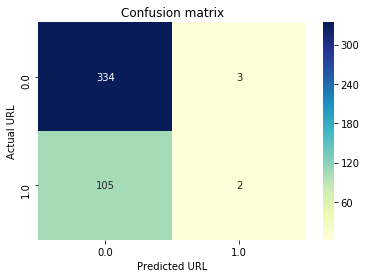

In [22]:
lr=ufp.prepareLR(dflr,0.3,123)
ufp.prepareCM(lr[3],lr[4])

In [23]:
ufp.prepareA(lr[0],lr[2],lr[3],lr[4],lr[6])

The training accuracy 0.7514506769825918
The testing accuracy: 0.7567567567567568
Precision: 0.4
Recall: 0.018691588785046728


In [24]:
df_new=ufp.prepareP(dflr,lr[3],lr[4],lr[5],lr[6])
df_new

,ID,Name,Link position,Score,Suggested URL,URL,predict_x,0,1
0,000000000,National Statistical Institute,0.0,66.000000,https://www.nsi.bg/en,NaN,1.0,0.430644,0.569356
1,000000000,National Statistical Institute,1.0,0.000000,https://www.ine.es/en/welcome.shtml,NaN,0.0,0.783717,0.216283
2,000000000,National Statistical Institute,2.0,5.666667,https://www.nsi.bg/en/content/11223/statistica...,NaN,0.0,0.760049,0.239951
3,000000000,National Statistical Institute,3.0,2.250000,http://www.insse.ro/cms/en,NaN,0.0,0.774527,0.225473
4,000000000,National Statistical Institute,6.0,0.000000,https://www.niss.org/,NaN,1.0,0.783717,0.216283
5,000000000,National Statistical Institute,8.0,0.000000,https://statinja.gov.jm/,NaN,1.0,0.783717,0.216283
6,000000000,National Statistical Institute,9.0,0.200000,https://www.ons.gov.uk/,NaN,1.0,0.782911,0.217089
7,000000001,STATISTIK AUSTRIA,0.0,95.000000,https://www.statistik.at/,http://www.statistik.at,1.0,0.412998,0.587002
8,000000001,STATISTIK AUSTRIA,2.0,31.666667,http://www.statistik-austria.at/,http://www.statistik.at,1.0,0.618470,0.381530
9,000000001,STATISTIK AUSTRIA,3.0,0.000000,https://www.alexa.com/siteinfo/statistik-austr...,http://www.statistik.at,0.0,0.774649,0.225351


In [25]:
df_sug=ufp.prepareS(df_new)
df_sug

,ID,Name,Link position,Score,Suggested URL,URL,predict_x,0,1
322,000000047,Statistics Iceland,0.0,94.00,https://www.statice.is/,https://statice.is/,1.0,0.269613,0.730387
329,000000048,Statistics Iceland,0.0,94.00,https://www.statice.is/,https://hagstofa.is/,1.0,0.269613,0.730387
12,000000002,STATISTIK AUSTRIA,0.0,95.00,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
17,000000003,STATISTIK AUSTRIA,0.0,95.00,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
22,000000004,STATISTIK AUSTRIA,0.0,95.00,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
27,000000005,STATISTIK AUSTRIA,0.0,95.00,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
336,000000049,Statistics Iceland,0.0,94.00,https://www.statice.is/,NaN,1.0,0.280118,0.719882
254,000000038,Statistics Denmark,0.0,82.00,https://www.dst.dk/en,NaN,1.0,0.340959,0.659041
1228,000000175,Statistics Faroe Islands,0.0,68.00,https://www.hagstova.fo/,https://hagstova.fo,1.0,0.406270,0.593730
1213,000000173,Statistics Faroe Islands,0.0,68.00,https://www.hagstova.fo/,https://hagstova.fo,1.0,0.406270,0.593730


In [26]:
df_sel=ufp.prepareSS(df_sug,0.5,True)
df_sel

,ID,Name,Link position,Score,Suggested URL,URL,predict_x,0,1
322,000000047,Statistics Iceland,0.0,94.0,https://www.statice.is/,https://statice.is/,1.0,0.269613,0.730387
329,000000048,Statistics Iceland,0.0,94.0,https://www.statice.is/,https://hagstofa.is/,1.0,0.269613,0.730387
12,000000002,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
17,000000003,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
22,000000004,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
27,000000005,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
336,000000049,Statistics Iceland,0.0,94.0,https://www.statice.is/,NaN,1.0,0.280118,0.719882
254,000000038,Statistics Denmark,0.0,82.0,https://www.dst.dk/en,NaN,1.0,0.340959,0.659041
1228,000000175,Statistics Faroe Islands,0.0,68.0,https://www.hagstova.fo/,https://hagstova.fo,1.0,0.406270,0.593730
1213,000000173,Statistics Faroe Islands,0.0,68.0,https://www.hagstova.fo/,https://hagstova.fo,1.0,0.406270,0.593730


In [27]:
df_sel=ufp.prepareSS(df_sug,0.5,False)
df_sel

,ID,Name,Link position,Score,Suggested URL,URL,predict_x,0,1
12,000000002,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
17,000000003,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
22,000000004,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
27,000000005,STATISTIK AUSTRIA,0.0,95.0,https://www.statistik.at/,NaN,1.0,0.275356,0.724644
336,000000049,Statistics Iceland,0.0,94.0,https://www.statice.is/,NaN,1.0,0.280118,0.719882
254,000000038,Statistics Denmark,0.0,82.0,https://www.dst.dk/en,NaN,1.0,0.340959,0.659041
771,000000117,Statistics Poland,0.0,69.0,https://stat.gov.pl/en/,NaN,1.0,0.413277,0.586723
1220,000000174,Statistics Faroe Islands,0.0,68.0,https://www.hagstova.fo/,NaN,1.0,0.419044,0.580956
763,000000116,Statistics Poland,0.0,67.0,https://stat.gov.pl/en/,NaN,1.0,0.424834,0.575166
263,000000039,Statistics Denmark,0.0,67.0,https://www.dst.dk/en,NaN,1.0,0.424834,0.575166


In [28]:
logging.info('End {0}'.format(title))